## This notebook evaluates classical ML models on the CSQADataset to detect code smells using only software metrics. Results will later be compared with transformer-based models trained on source code.

## Splitting and Normalizing the CSQA Dataset

Before training classical machine learning models (e.g., Random Forest, SVM, XGBoost), we perform two essential preprocessing steps:

1. **Train/Test Split**
   The dataset is divided into two subsets:
   - **Training set** – used to fit the model.
   - **Test set** – used to evaluate generalization performance.

   We apply *stratified sampling* to ensure the label distribution remains consistent across both sets. This is especially important for imbalanced datasets.

2. **Feature Normalization**
   Standardization is applied to all feature columns using `StandardScaler`, which transforms features to have **zero mean** and **unit variance**.
   This step is crucial for distance-based models such as **SVM** and **KNN**, which are sensitive to feature scales.

---

Now, let’s load the merged CSQA dataset and prepare it for training using the `split_and_scale` function.
This function drops irrelevant columns (`smell`, `level`), removes missing labels, and scales numeric features.
The `smell` and `level` columns needs to be removed due to the following reasons:

### `smell` (Type of Code Smell)
- This column indicates the **type of code smell**, such as `LongMethod`, `GodClass`, etc.
- When training a separate classifier for each smell type (e.g., only for `LongMethod`), this column contains the **same value for all rows**, providing no useful information.
- If multiple smell types are included together, this column becomes a **proxy for the label**, leading to **data leakage** and artificially high model accuracy.
- Keeping it would therefore **reduce model generalization** and **invalidate evaluation results**.

### `level` (Granularity Level: Class, Method, Field)
- This column describes the **granularity level** of the code entity (e.g., class-level, method-level).
- For datasets focused on a single level (e.g., only method-level smells), it remains constant and adds no value.
- In mixed-level datasets, it may correlate with specific smell types, acting as **metadata rather than a true feature**.
- Including it can **bias the model** toward structural rather than semantic patterns.

Both columns serve as metadata for organizing and labeling samples, but they do **not contain predictive signal** relevant to code smell detection.
To ensure fair and valid training, these columns are **excluded from the feature set** prior to model fitting.

In [2]:
import numpy as np
import pandas as pd
import sys
sys.path.append('../src')
from data_processing.csqa_prepare import split_and_scale

csqa_df = pd.read_csv('../data/processed/csqa_merged_metrics.csv')

X_train, X_test, y_train, y_test, scaler = split_and_scale(csqa_df, label_col='label')

print("Any NaNs in X_train?", np.isnan(X_train).any())
print("Any NaNs in X_test?", np.isnan(X_test).any())

print(f"\nTrain set size: {X_train.shape}, Test set size: {X_test.shape}")
print(f"\nLabel distribution in train set:\n{y_train.value_counts(normalize=True)}")
print(f"\nLabel distribution in test set:\n{y_test.value_counts(normalize=True)}")
print(f"\nFirst 5 rows of scaled training features:\n{X_train[:5]}")

Any NaNs in X_train? False
Any NaNs in X_test? False

Train set size: (3244992, 96), Test set size: (811249, 96)

Label distribution in train set:
label
0    0.996595
1    0.003405
Name: proportion, dtype: float64

Label distribution in test set:
label
0    0.996595
1    0.003405
Name: proportion, dtype: float64

First 5 rows of scaled training features:
[[-8.52838794e-02 -2.24522494e-01 -4.98199175e-01 -1.84375228e-01
  -1.37638296e-01  1.52183310e-01 -1.12711349e-01 -5.94996039e-02
  -6.06569271e-02 -8.79119156e-02 -4.29747693e-02 -1.46970637e-01
  -3.04259504e-01 -1.56025490e-02 -2.84386794e-01 -5.76854203e-02
  -4.99891483e-02 -2.92790906e-02 -5.48577744e-02 -2.81944696e-01
  -2.28648136e-01 -1.54594467e-01 -9.42441107e-03 -4.24431379e-02
  -4.17520014e-02 -3.88515044e-01 -7.79583539e-02 -7.66665958e-02
  -7.73489241e-02 -7.00576693e-02 -8.42914262e-02 -4.64163414e-03
  -8.77948039e-02 -8.62740410e-02 -9.42960909e-02 -1.12433607e-02
  -1.18590068e-01 -8.90474127e-02  1.96603318e-02

### Step 2: Balancing the Training Set with SMOTE

The dataset is highly imbalanced (~0.34% positive class). To address this, we apply SMOTE (Synthetic Minority Oversampling Technique)
to generate synthetic examples for the minority class.

In [3]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Before SMOTE: {dict(pd.Series(y_train).value_counts())}")
print(f"After SMOTE: {dict(pd.Series(y_train_resampled).value_counts())}")

Before SMOTE: {0: np.int64(3233943), 1: np.int64(11049)}
After SMOTE: {0: np.int64(3233943), 1: np.int64(3233943)}


### What does this mean?

- **Before SMOTE**:
  - Class `0` (clean samples): **3,233,943** instances
  - Class `1` (smelly code): **11,049** instances
This shows **extreme class imbalance**, with less than 0.35% of samples being labeled as code smell.

- **After SMOTE (Synthetic Minority Oversampling Technique)**:
  - SMOTE generated **synthetic examples** for class `1` to **match the number of samples in the majority class**.
  - Now both classes have **3,233,943** samples.
This results in a **balanced dataset**, which is crucial for training many classification algorithms that would otherwise be biased toward the majority class.

This is the **expected behavior** of SMOTE when using default settings.
SMOTE oversamples **only the minority class** until it matches the majority class.
This is especially helpful for training models that are sensitive to class imbalance (e.g., Logistic Regression, SVM, Random Forest, etc.).

The output confirms that SMOTE successfully balanced the dataset.
Now we can now proceed with training your classifier on the balanced training set.

### Train RandomForest Classifier with Balanced Class Weights

We use a Random Forest classifier with `class_weight='balanced'` to further mitigate the effect of class imbalance.
This instructs the model to penalize misclassifications of the minority class more heavily.

In [4]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(
    class_weight='balanced',
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

clf.fit(X_train_resampled, y_train_resampled)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


###  Evaluate the Classifier Using Balanced Metrics

Since accuracy can be misleading for imbalanced data, we evaluate the model using:
- **Precision**
- **Recall**
- **F1-score**
- **ROC-AUC**
- **Average Precision (PR AUC)**

These metrics are more informative in imbalanced classification tasks.

In [5]:
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))
print("Average Precision Score:", average_precision_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    808487
           1       0.81      0.96      0.88      2762

    accuracy                           1.00    811249
   macro avg       0.91      0.98      0.94    811249
weighted avg       1.00      1.00      1.00    811249

ROC-AUC Score: 0.9944207074677327
Average Precision Score: 0.9591041604794874


### Visualize Precision-Recall Curve

The precision-recall curve is especially useful for highly imbalanced binary classification problems,
as it better reflects model performance for the minority class.

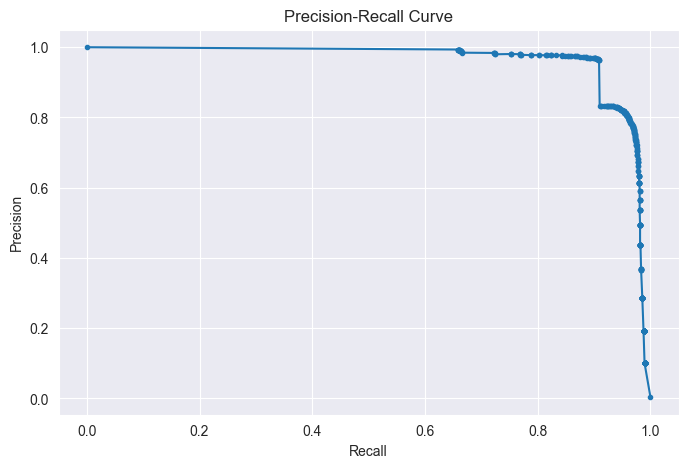

In [6]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(8, 5))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

## 💾 Saving and Loading the Trained Model

We use the `joblib` library to serialize the trained classifier to disk. This allows us to reload the exact same model and preprocessing pipeline later.
We also store the `StandardScaler`, which is required to properly transform new input data using the same statistics as during training.

### 📤 Saving the model and scaler

```python
import joblib

# Save the trained classifier and scaler
joblib.dump(clf, '../models/random_forest_smell_model.pkl')
joblib.dump(scaler, '../models/standard_scaler.pkl')

# Load the previously saved classifier and scaler
clf_loaded = joblib.load('../models/random_forest_smell_model.pkl')
scaler_loaded = joblib.load('../models/standard_scaler.pkl')

# Example: Making predictions on new data
X_new_scaled = scaler_loaded.transform(X_new)
y_pred = clf_loaded.predict(X_new_scaled)

In [7]:
import joblib

joblib.dump(clf, '../models/random_forest_smell_model.pkl')
joblib.dump(scaler, '../models/standard_scaler.pkl')

['../models/standard_scaler.pkl']